In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from tensorflow.keras.optimizers import Adam

# Import Data

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Data/Data%20TMA%20(Daily%202022-2025).csv')
data = data.loc[:, ['Daily_Period','TMA_Daily']]
data = data.iloc[:1216].reset_index(drop=True)

print(data.head())
print(data.tail())
print(data.shape)

  Daily_Period  TMA_Daily
0   01/01/2022       10.0
1   02/01/2022       10.0
2   03/01/2022       10.0
3   04/01/2022       10.0
4   05/01/2022       12.5
     Daily_Period  TMA_Daily
1211   26/04/2025  20.000000
1212   27/04/2025  20.000000
1213   28/04/2025  21.666667
1214   29/04/2025  20.000000
1215   30/04/2025  14.166667
(1216, 2)


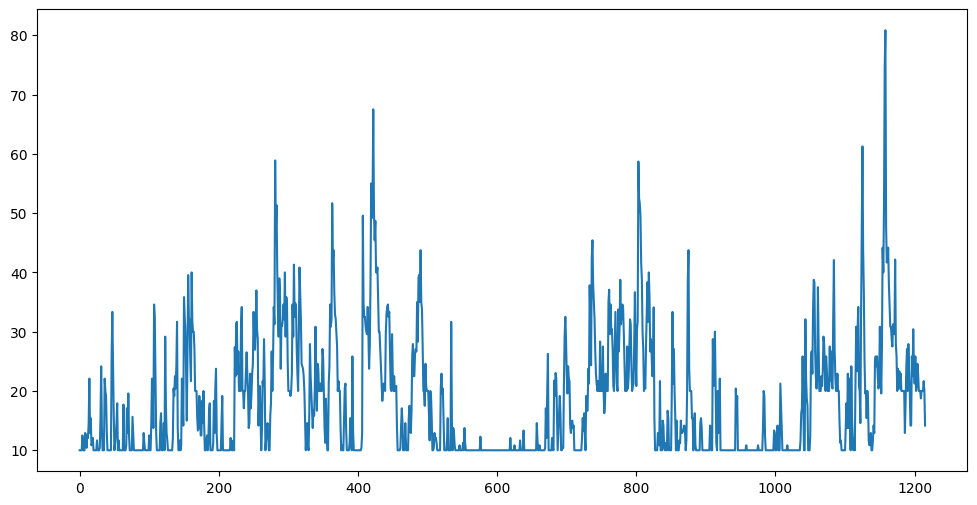

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(data['TMA_Daily'])

# Normalisasi Data

Proses normalisasi data dilakukan menggunakan metode min-max normalization hingga menghasilkan data yang berskala [0,1].

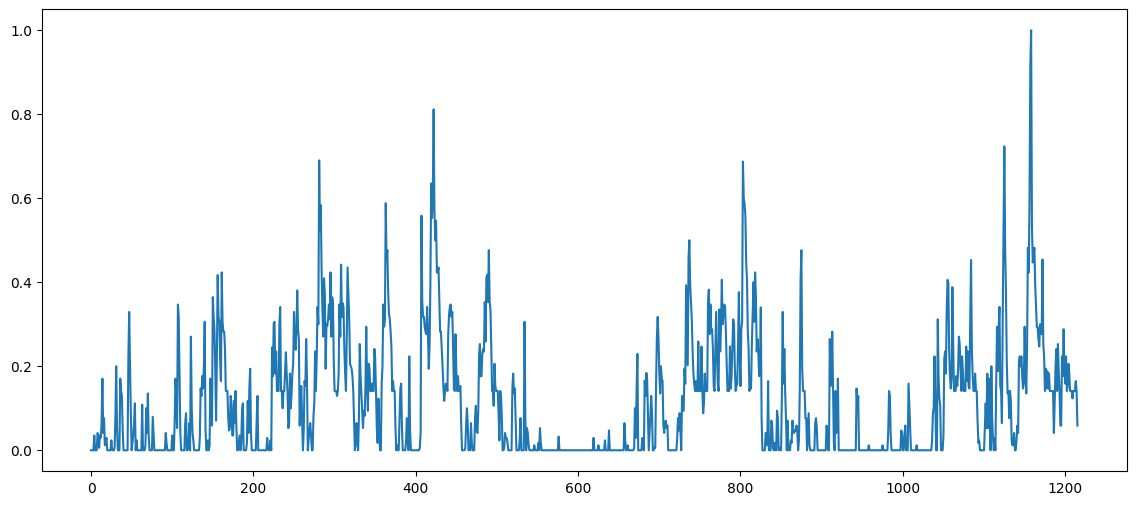

In [5]:
# Step 1: Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data['TMA_normalized'] = scaler.fit_transform(data['TMA_Daily'].values.reshape(-1, 1))
plt.figure(figsize=(14, 6))
plt.plot(data['TMA_normalized'])

# Hyperparameter Tuning & Cross Validation

Hyperparameter tuning dilakukan untuk menentukan hyperparameter terbaik melalui langkah validasi berupa *time series k-fold cross validation*. Banyaknya fold yang digunakan dalam langkah validasi adalah sebanyak k = 5 fold.

In [6]:
data_series = data['TMA_normalized'].values
data_series = data_series.reshape((len(data_series), 1))
data_series

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.16470588],
       [0.14117647],
       [0.05882353]])

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def create_model(neurons, learning_rate):
  seed = 42
  np.random.seed(seed)
  tf.random.set_seed(seed)
  random.seed(seed)
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(30, 1), return_sequences=True))
  model.add(LSTM(16))
  model.add(Dropout(0.01))
  model.add(Dense(1))
  optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model

In [8]:
import keras

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # print('abcd')
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

## Sliding Window Cross Validation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0088 - val_loss: 0.0276
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0051 - val_loss: 0.0215
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0181
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0222
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0161
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0137
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0165
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 0.0244
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0103
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0182
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - val_loss: 0.0194
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0100

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0371 - val_loss: 0.0388
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0182 - val_loss: 0.0343
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0142 - val_loss: 0.0460
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - val_loss: 0.0199
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0093 - val_loss: 0.0238
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0102 - val_loss: 0.0185
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0226
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0252
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0172
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - val_loss: 0.0205
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.0210
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 7.5271e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039 - val_loss: 1.4874e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 1.4899e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 1.5931e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 7.0120e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 4.4545e-04
Epoch 8/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 9.3541e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 3.7868016386841807 %
mape test = 21.3581104258373 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0524 - val_loss: 0.0121
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0189 - val_loss: 0.0066
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0147 - val_loss: 0.0048
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0166 - val_loss: 0.0107
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - val_loss: 0.0049
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0038
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0031
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0055
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.0130

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0131 - val_loss: 0.0208
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0159
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0124
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - val_loss: 0.0097
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0160
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0100
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0104
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
mape validation = 23.29152857467785 %
m

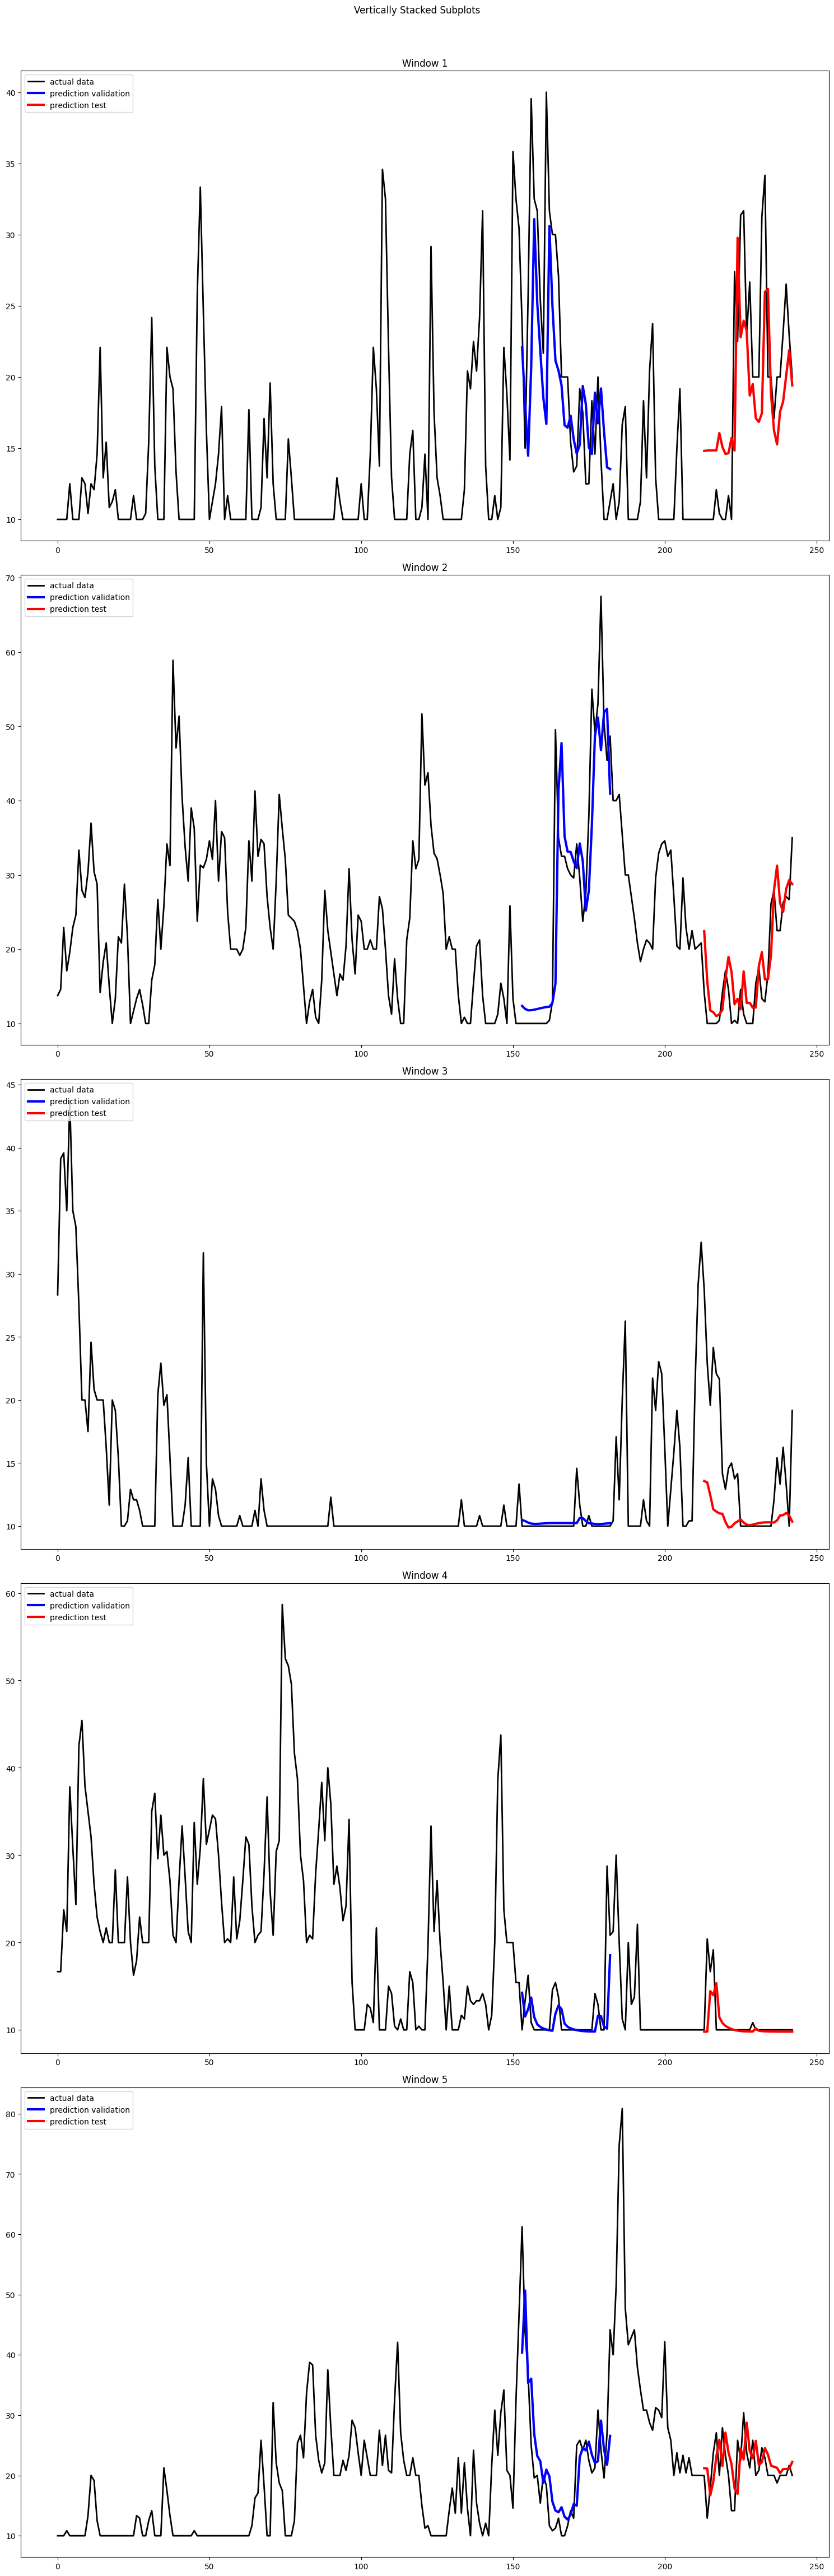


Final Average MAPE Validation: 0.1632
Final Average MAPE Test: 0.1948
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0088 - val_loss: 0.0276
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0215
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0181
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0222
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0161
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0137
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0037 - val_loss: 0.0165
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0029 - val_loss: 0.0244
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0103
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0182
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0194
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.010

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0371 - val_loss: 0.0388
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0182 - val_loss: 0.0343
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0142 - val_loss: 0.0460
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - val_loss: 0.0199
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0238
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0102 - val_loss: 0.0185
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0099 - val_loss: 0.0226
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0090 - val_loss: 0.0252
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0172
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - val_loss: 0.0205
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.0210
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 7.5271e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039 - val_loss: 1.4874e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 1.4899e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 1.5931e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 7.0120e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 4.4545e-04
Epoch 8/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 9.3541e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 3.7868016386841807 %
mape test = 21.3581104258373 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0524 - val_loss: 0.0121
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0189 - val_loss: 0.0066
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0147 - val_loss: 0.0048
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0166 - val_loss: 0.0107
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0049
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0038
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0077 - val_loss: 0.0031
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0104 - val_loss: 0.0055
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0110 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0131 - val_loss: 0.0208
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0159
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0124
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0081 - val_loss: 0.0097
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0160
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0100
Epoch 9/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - val_loss: 0.0104
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 23.29152857467785 %

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1632
Final Average MAPE Test: 0.1948
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0088 - val_loss: 0.0276
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0215
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0181
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0059 - val_loss: 0.0222
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044 - val_loss: 0.0161
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0137
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0165
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 0.0244
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0103
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0182
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0194
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0371 - val_loss: 0.0388
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0182 - val_loss: 0.0343
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0142 - val_loss: 0.0460
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101 - val_loss: 0.0199
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0238
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0102 - val_loss: 0.0185
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0099 - val_loss: 0.0226
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0090 - val_loss: 0.0252
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0172
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - val_loss: 0.0205
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.0210
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 7.5271e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039 - val_loss: 1.4874e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 1.4899e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 1.5931e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 7.0120e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 4.4545e-04
Epoch 8/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 9.3541e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 3.7868016386841807 %
mape test = 21.3581104258373 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0524 - val_loss: 0.0121
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0189 - val_loss: 0.0066
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0147 - val_loss: 0.0048
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0166 - val_loss: 0.0107
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0049
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0038
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0077 - val_loss: 0.0031
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0055
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0110 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0131 - val_loss: 0.0208
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0060 - val_loss: 0.0159
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0077 - val_loss: 0.0124
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - val_loss: 0.0097
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0160
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0100
Epoch 9/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0104
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 23.29152857467785 %

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1632
Final Average MAPE Test: 0.1948
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0088 - val_loss: 0.0276
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - val_loss: 0.0215
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046 - val_loss: 0.0181
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0222
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0161
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0137
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0165
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 0.0244
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0103
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0182
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0194
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0371 - val_loss: 0.0388
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0182 - val_loss: 0.0343
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0142 - val_loss: 0.0460
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - val_loss: 0.0199
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0238
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0102 - val_loss: 0.0185
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0226
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0252
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0172
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - val_loss: 0.0205
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.0210
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 7.5271e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 1.4874e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 1.4899e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0054 - val_loss: 1.5931e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 7.0120e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 4.4545e-04
Epoch 8/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 9.3541e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 3.7868016386841807 %
mape test = 21.3581104258373 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0524 - val_loss: 0.0121
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0189 - val_loss: 0.0066
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0147 - val_loss: 0.0048
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0166 - val_loss: 0.0107
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0097 - val_loss: 0.0049
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - val_loss: 0.0038
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0031
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0055
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0131 - val_loss: 0.0208
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0159
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0124
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - val_loss: 0.0097
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0160
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0059 - val_loss: 0.0100
Epoch 9/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0055 - val_loss: 0.0104
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 23.29152857467785 

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1632
Final Average MAPE Test: 0.1948
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0268 - val_loss: 0.0282
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056 - val_loss: 0.0234
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0186
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0356
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0236
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - val_loss: 0.0378
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0211
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0062 - val_loss: 0.0615
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 31.528990148640464 %
mape test = 38.47880540905674 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0762 - val_loss: 0.0686
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0315 - val_loss: 0.0660
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0269 - val_loss: 0.0626
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.0457
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0140 - val_loss: 0.0301
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0210
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0128 - val_loss: 0.0213
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0082 - val_loss: 0.0190
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0097 - val_loss: 0.0157
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - val_loss: 0.0260
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0155 - val_loss: 0.0317
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0184 - val_loss: 0.03

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0157 - val_loss: 0.0044
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 8.1099e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0050 - val_loss: 7.6483e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0030 - val_loss: 7.3943e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0060 - val_loss: 1.5352e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 7.5162e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 5.1808e-04
Epoch 10/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 6.3859e-04
Epoch 00010: early stopping
3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0680 - val_loss: 0.0175
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0299 - val_loss: 0.0223
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0301 - val_loss: 0.0312
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0334 - val_loss: 0.0551
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0335 - val_loss: 0.0117
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0231 - val_loss: 0.0378
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0257 - val_loss: 0.0167
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0191 - val_loss: 0.0149
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0170 - val_loss: 0.0060
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0145 - val_loss: 0.0044
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132 - val_loss: 0.002

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0443 - val_loss: 0.0273
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0150
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0247
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0106 - val_loss: 0.0148
Epoch 8/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - val_loss: 0.0126
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 18.356266183212448 %
mape test = 17.212968133075226 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1976
Final Average MAPE Test: 0.2529
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0268 - val_loss: 0.0282
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0234
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0186
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - val_loss: 0.0356
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0236
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - val_loss: 0.0378
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0044 - val_loss: 0.0211
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0062 - val_loss: 0.0615
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 31.528990148640464 %
mape test = 38.47880540905674 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0762 - val_loss: 0.0686
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0315 - val_loss: 0.0660
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0269 - val_loss: 0.0626
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0152 - val_loss: 0.0457
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0140 - val_loss: 0.0301
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0099 - val_loss: 0.0210
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0128 - val_loss: 0.0213
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0082 - val_loss: 0.0190
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0097 - val_loss: 0.0157
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0119 - val_loss: 0.0260
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0155 - val_loss: 0.0317
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0184 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0157 - val_loss: 0.0044
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 8.1099e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 7.6483e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0030 - val_loss: 7.3943e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0060 - val_loss: 1.5352e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 7.5162e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 5.1808e-04
Epoch 10/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 6.3859e-04
Epoch 00010: early stopping
30

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0680 - val_loss: 0.0175
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0299 - val_loss: 0.0223
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0301 - val_loss: 0.0312
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0334 - val_loss: 0.0551
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0335 - val_loss: 0.0117
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0231 - val_loss: 0.0378
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0257 - val_loss: 0.0167
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0191 - val_loss: 0.0149
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0170 - val_loss: 0.0060
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0145 - val_loss: 0.0044
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0443 - val_loss: 0.0273
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0150
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0247
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0106 - val_loss: 0.0148
Epoch 8/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - val_loss: 0.0126
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 18.356266183212448 %
mape test = 17.212968133075226 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1976
Final Average MAPE Test: 0.2529
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0268 - val_loss: 0.0282
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056 - val_loss: 0.0234
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057 - val_loss: 0.0186
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0356
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0236
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - val_loss: 0.0378
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0044 - val_loss: 0.0211
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0062 - val_loss: 0.0615
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 31.528990148640464 %
mape test = 38.47880540905674 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0762 - val_loss: 0.0686
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0315 - val_loss: 0.0660
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0269 - val_loss: 0.0626
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.0457
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0140 - val_loss: 0.0301
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0210
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0128 - val_loss: 0.0213
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0082 - val_loss: 0.0190
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0157
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119 - val_loss: 0.0260
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0155 - val_loss: 0.0317
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0184 - val_loss: 0.03

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0157 - val_loss: 0.0044
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0025 - val_loss: 8.1099e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 7.6483e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 7.3943e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 1.5352e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 7.5162e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - val_loss: 5.1808e-04
Epoch 10/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - val_loss: 6.3859e-04
Epoch 00010: early stopping
30/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0680 - val_loss: 0.0175
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0299 - val_loss: 0.0223
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0301 - val_loss: 0.0312
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0334 - val_loss: 0.0551
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0335 - val_loss: 0.0117
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0231 - val_loss: 0.0378
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0257 - val_loss: 0.0167
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0191 - val_loss: 0.0149
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0170 - val_loss: 0.0060
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0145 - val_loss: 0.0044
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132 - val_loss: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0443 - val_loss: 0.0273
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0100 - val_loss: 0.0150
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0247
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0106 - val_loss: 0.0148
Epoch 8/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0126
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 18.356266183212448 %
mape test = 17.212968133075226 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1976
Final Average MAPE Test: 0.2529
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0268 - val_loss: 0.0282
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0056 - val_loss: 0.0234
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057 - val_loss: 0.0186
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0356
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0236
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - val_loss: 0.0378
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0211
Epoch 8/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0615
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 31.528990148640464 %
mape test = 38.47880540905674 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0762 - val_loss: 0.0686
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0315 - val_loss: 0.0660
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0269 - val_loss: 0.0626
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0152 - val_loss: 0.0457
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0140 - val_loss: 0.0301
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0099 - val_loss: 0.0210
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0128 - val_loss: 0.0213
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 0.0190
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0157
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - val_loss: 0.0260
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0155 - val_loss: 0.0317
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0184 - val_loss: 0.03

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0157 - val_loss: 0.0044
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 8.1099e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 7.6483e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - val_loss: 7.3943e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 1.5352e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 7.5162e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 5.1808e-04
Epoch 10/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0022 - val_loss: 6.3859e-04
Epoch 00010: early stopping
30

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0680 - val_loss: 0.0175
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0299 - val_loss: 0.0223
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0301 - val_loss: 0.0312
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0334 - val_loss: 0.0551
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0335 - val_loss: 0.0117
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0231 - val_loss: 0.0378
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0257 - val_loss: 0.0167
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0191 - val_loss: 0.0149
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0170 - val_loss: 0.0060
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0145 - val_loss: 0.0044
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0132 - val_loss: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0443 - val_loss: 0.0273
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0100 - val_loss: 0.0150
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0247
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0148
Epoch 8/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0126
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 18.356266183212448 %
mape test = 17.212968133075226 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1976
Final Average MAPE Test: 0.2529
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0072 - val_loss: 0.0334
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0047 - val_loss: 0.0246
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046 - val_loss: 0.0287
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0066 - val_loss: 0.0254
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0262
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - val_loss: 0.0280
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0230
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0186
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0288
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - val_loss: 0.0208
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - val_loss: 0.0229
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0426 - val_loss: 0.0499
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0255 - val_loss: 0.0504
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0236 - val_loss: 0.0374
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0145 - val_loss: 0.0313
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0141 - val_loss: 0.0295
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0123 - val_loss: 0.0288
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0130 - val_loss: 0.0296
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0273
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0242
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0117 - val_loss: 0.0250
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - val_loss: 0.0214
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0011 - val_loss: 3.7266e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 4.2870e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - val_loss: 1.5597e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 2.2741e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 1.9083e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 2.5912e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 5.3055e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 1.5062e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - val_loss: 1.4976e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 2.5671e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 1.8174e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0529 - val_loss: 0.0051
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0230 - val_loss: 0.0057
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0182 - val_loss: 0.0074
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0202 - val_loss: 0.0062
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0177 - val_loss: 0.0056
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0134 - val_loss: 0.0048
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161 - val_loss: 0.0044
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0132 - val_loss: 0.0053
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0116 - val_loss: 0.0039
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0104 - val_loss: 0.0039
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.006

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0107 - val_loss: 0.0303
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - val_loss: 0.0303
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.0300
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - val_loss: 0.0256
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0082 - val_loss: 0.0242
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0111 - val_loss: 0.0246
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.0251
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - val_loss: 0.0229
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0214
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - val_loss: 0.0200
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.0210
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.02

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2149
Final Average MAPE Test: 0.2287
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0072 - val_loss: 0.0334
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - val_loss: 0.0246
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0287
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0254
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0262
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0067 - val_loss: 0.0280
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037 - val_loss: 0.0230
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0186
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0288
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0208
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0229
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0426 - val_loss: 0.0499
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0255 - val_loss: 0.0504
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0236 - val_loss: 0.0374
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0145 - val_loss: 0.0313
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0141 - val_loss: 0.0295
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0123 - val_loss: 0.0288
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0130 - val_loss: 0.0296
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0273
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0242
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0117 - val_loss: 0.0250
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - val_loss: 0.0214
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - val_loss: 0.021

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0011 - val_loss: 3.7266e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 4.2870e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 1.5597e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 2.2741e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 1.9083e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 2.5912e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 5.3055e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0026 - val_loss: 1.5062e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 1.4976e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 2.5671e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 1.8174e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0529 - val_loss: 0.0051
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0230 - val_loss: 0.0057
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0182 - val_loss: 0.0074
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0202 - val_loss: 0.0062
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0177 - val_loss: 0.0056
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0134 - val_loss: 0.0048
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161 - val_loss: 0.0044
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132 - val_loss: 0.0053
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0116 - val_loss: 0.0039
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0039
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0107 - val_loss: 0.0303
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0303
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - val_loss: 0.0300
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0256
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0082 - val_loss: 0.0242
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0111 - val_loss: 0.0246
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.0251
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - val_loss: 0.0229
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0214
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - val_loss: 0.0200
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.0210
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.02

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2149
Final Average MAPE Test: 0.2287
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0072 - val_loss: 0.0334
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0246
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0287
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0254
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0262
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0067 - val_loss: 0.0280
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0230
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0037 - val_loss: 0.0186
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0061 - val_loss: 0.0288
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0208
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0229
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0426 - val_loss: 0.0499
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0255 - val_loss: 0.0504
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0236 - val_loss: 0.0374
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0145 - val_loss: 0.0313
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0141 - val_loss: 0.0295
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0123 - val_loss: 0.0288
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0130 - val_loss: 0.0296
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0104 - val_loss: 0.0273
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0242
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0117 - val_loss: 0.0250
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - val_loss: 0.0214
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011 - val_loss: 3.7266e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 4.2870e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - val_loss: 1.5597e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 2.2741e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 1.9083e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 2.5912e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 5.3055e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 1.5062e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 1.4976e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 2.5671e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 1.8174e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0529 - val_loss: 0.0051
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0230 - val_loss: 0.0057
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0182 - val_loss: 0.0074
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0202 - val_loss: 0.0062
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0177 - val_loss: 0.0056
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0134 - val_loss: 0.0048
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161 - val_loss: 0.0044
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0132 - val_loss: 0.0053
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0116 - val_loss: 0.0039
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0039
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0107 - val_loss: 0.0303
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0303
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - val_loss: 0.0300
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0256
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 0.0242
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0111 - val_loss: 0.0246
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.0251
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - val_loss: 0.0229
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - val_loss: 0.0214
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - val_loss: 0.0200
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.0210
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.020

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2149
Final Average MAPE Test: 0.2287
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0072 - val_loss: 0.0334
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - val_loss: 0.0246
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0287
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0254
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - val_loss: 0.0262
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0067 - val_loss: 0.0280
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037 - val_loss: 0.0230
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0186
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0288
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - val_loss: 0.0208
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - val_loss: 0.0229
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0426 - val_loss: 0.0499
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0255 - val_loss: 0.0504
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0236 - val_loss: 0.0374
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0145 - val_loss: 0.0313
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0141 - val_loss: 0.0295
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0123 - val_loss: 0.0288
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0130 - val_loss: 0.0296
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0104 - val_loss: 0.0273
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0099 - val_loss: 0.0242
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0117 - val_loss: 0.0250
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - val_loss: 0.0214
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0011 - val_loss: 3.7266e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 4.2870e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0036 - val_loss: 1.5597e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 2.2741e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 1.9083e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 2.5912e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 5.3055e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 1.5062e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 1.4976e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 2.5671e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 1.8174e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0529 - val_loss: 0.0051
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0230 - val_loss: 0.0057
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0182 - val_loss: 0.0074
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0202 - val_loss: 0.0062
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0177 - val_loss: 0.0056
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0134 - val_loss: 0.0048
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161 - val_loss: 0.0044
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0132 - val_loss: 0.0053
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0116 - val_loss: 0.0039
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0039
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0099 - val_loss: 0.006

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0107 - val_loss: 0.0303
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - val_loss: 0.0303
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.0300
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0256
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 0.0242
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - val_loss: 0.0246
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.0251
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - val_loss: 0.0229
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - val_loss: 0.0214
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0084 - val_loss: 0.0200
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0080 - val_loss: 0.0210
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.020

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2149
Final Average MAPE Test: 0.2287
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0083 - val_loss: 0.0293
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - val_loss: 0.0231
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0234
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064 - val_loss: 0.0258
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0161
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0170
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - val_loss: 0.0159
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 0.0155
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0048 - val_loss: 0.0168
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0079 - val_loss: 0.0188
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0405 - val_loss: 0.0466
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0221 - val_loss: 0.0419
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0164 - val_loss: 0.0348
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - val_loss: 0.0195
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0095 - val_loss: 0.0228
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0105 - val_loss: 0.0196
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0227
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0226
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0182
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0201
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - val_loss: 0.0201
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 4.8071e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - val_loss: 1.4887e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 1.5534e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 1.6405e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 7.8034e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 1.5934e-04
Epoch 8/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 5.2004e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 3.71293069404104 %
mape test = 21.123216884124236 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0477 - val_loss: 0.0084
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0191 - val_loss: 0.0049
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0153 - val_loss: 0.0058
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0167 - val_loss: 0.0070
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0030
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0034
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 10/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0127 - val_loss: 0.0235
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - val_loss: 0.0204
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - val_loss: 0.0180
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0089 - val_loss: 0.0158
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0151
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0146
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0115
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0056 - val_loss: 0.0108
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0112
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0111
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - val_loss: 0.01

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1733
Final Average MAPE Test: 0.1953
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0083 - val_loss: 0.0293
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0231
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0234
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - val_loss: 0.0258
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - val_loss: 0.0161
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0055 - val_loss: 0.0170
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - val_loss: 0.0159
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 0.0155
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0168
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0188
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.009

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0405 - val_loss: 0.0466
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0221 - val_loss: 0.0419
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0164 - val_loss: 0.0348
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - val_loss: 0.0195
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.0228
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0196
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0106 - val_loss: 0.0227
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0226
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - val_loss: 0.0182
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0201
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0107 - val_loss: 0.0201
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0095 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 4.8071e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 1.4887e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - val_loss: 1.5534e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 1.6405e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 7.8034e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 1.5934e-04
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss: 5.2004e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 3.71293069404104 %
mape test = 21.123216884124236 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0477 - val_loss: 0.0084
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0191 - val_loss: 0.0049
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0153 - val_loss: 0.0058
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0167 - val_loss: 0.0070
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0105 - val_loss: 0.0030
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - val_loss: 0.0034
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 10/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0127 - val_loss: 0.0235
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064 - val_loss: 0.0204
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0085 - val_loss: 0.0180
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0089 - val_loss: 0.0158
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - val_loss: 0.0151
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0092 - val_loss: 0.0146
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0115
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056 - val_loss: 0.0108
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0112
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - val_loss: 0.0111
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - val_loss: 0.01

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1733
Final Average MAPE Test: 0.1953
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0083 - val_loss: 0.0293
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0048 - val_loss: 0.0231
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046 - val_loss: 0.0234
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - val_loss: 0.0258
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0161
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0170
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - val_loss: 0.0159
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 0.0155
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - val_loss: 0.0168
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - val_loss: 0.0188
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0405 - val_loss: 0.0466
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0221 - val_loss: 0.0419
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0164 - val_loss: 0.0348
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - val_loss: 0.0195
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - val_loss: 0.0228
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0196
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0106 - val_loss: 0.0227
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0090 - val_loss: 0.0226
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - val_loss: 0.0182
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0201
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - val_loss: 0.0201
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 4.8071e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - val_loss: 1.4887e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 1.5534e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 1.6405e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 7.8034e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 1.5934e-04
Epoch 8/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0029 - val_loss: 5.2004e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 3.71293069404104 %
mape test = 21.123216884124236 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0477 - val_loss: 0.0084
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0191 - val_loss: 0.0049
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0153 - val_loss: 0.0058
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0167 - val_loss: 0.0070
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0105 - val_loss: 0.0030
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0034
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 10/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0127 - val_loss: 0.0235
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - val_loss: 0.0204
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - val_loss: 0.0180
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0089 - val_loss: 0.0158
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - val_loss: 0.0151
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0092 - val_loss: 0.0146
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0115
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0056 - val_loss: 0.0108
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0057 - val_loss: 0.0112
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0111
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - val_loss: 0.01

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1733
Final Average MAPE Test: 0.1953
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0083 - val_loss: 0.0293
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0231
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0234
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0064 - val_loss: 0.0258
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0054 - val_loss: 0.0161
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - val_loss: 0.0170
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - val_loss: 0.0159
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 0.0155
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - val_loss: 0.0168
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0188
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0405 - val_loss: 0.0466
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0221 - val_loss: 0.0419
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0164 - val_loss: 0.0348
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - val_loss: 0.0195
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.0228
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0196
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0227
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0226
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0182
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0106 - val_loss: 0.0201
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0107 - val_loss: 0.0201
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0095 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017 - val_loss: 4.8071e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - val_loss: 1.4887e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 1.5534e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 1.6405e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 7.8034e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 1.5934e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 5.2004e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 3.71293069404104 %
mape test = 21.123216884124236 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0477 - val_loss: 0.0084
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0191 - val_loss: 0.0049
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0153 - val_loss: 0.0058
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0167 - val_loss: 0.0070
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0030
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0034
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 10/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0127 - val_loss: 0.0235
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0064 - val_loss: 0.0204
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - val_loss: 0.0180
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0089 - val_loss: 0.0158
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0151
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0092 - val_loss: 0.0146
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - val_loss: 0.0115
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056 - val_loss: 0.0108
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057 - val_loss: 0.0112
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0062 - val_loss: 0.0111
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0083 - val_loss: 0.0

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1733
Final Average MAPE Test: 0.1953


In [9]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, figsize=(15, 15*5/1.6))
fig.suptitle('Vertically Stacked Subplots')

# Parameter Sliding Window Cross Validation
window_size = 243        # Train Window
n_test = 60              # Test Window
n_train_and_val = window_size - n_test
n_train = n_train_and_val - 60
shift = 243
n_windows1 = 5
n_total = len(data_series)
look_back = 30
time_step = 30

import itertools

config_params = {
    "learning_rate" : [0.01, 0.05, 0.001, 0.005],
    "batch_size" : [16, 32, 64, 128],
    "neurons" : [50],
}

average_mape_vals_by_param = []
average_mape_tests_by_param = []

for xs in itertools.product(*list(config_params.values())):
  current_param = dict()
  for i, key in enumerate(config_params.keys()):
    if key == "batch_size":
      bsize = xs[i]
    else:
      current_param[key] = xs[i]

  mape_vals = []
  mape_tests = []

  for i in range(n_windows1):
      start = i * shift
      end = start + window_size
      if end > n_total:
          print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
          break

      window_data = data_series[start:end] #sliding window
      train_and_val = window_data[:n_train_and_val]
      train = train_and_val[:n_train]
      val = train_and_val[n_train:]
      test = window_data[n_train_and_val:]

      try:

          train_generator = TimeseriesGenerator(train, train, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          val_generator = TimeseriesGenerator(val, val, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          test_generator = TimeseriesGenerator(test, test, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          model = create_model(current_param['neurons'], current_param['learning_rate'])

          # model.compile(optimizer='adam', loss='mean_squared_error')

          model.fit(train_generator, epochs=50, validation_data=val_generator, batch_size=bsize, callbacks=[EarlyStoppingAtMinLoss(patience=5)], verbose = 1)

          val_predictions = model.predict(val_generator)
          test_predictions  = model.predict(test_generator)

          val_predictions_descale = scaler.inverse_transform(val_predictions).flatten()
          test_predictions_descale = scaler.inverse_transform(test_predictions).flatten()

          train_actual = scaler.inverse_transform(train).flatten()
          val_actual = scaler.inverse_transform(val).flatten()
          test_actual = scaler.inverse_transform(test).flatten()

          all_actual = np.append(np.append(train_actual, val_actual), test_actual)

          mape_val = mean_absolute_percentage_error(val_actual[-len(val_generator):], val_predictions_descale)
          mape_test = mean_absolute_percentage_error(test_actual[-len(test_generator):], test_predictions_descale)

          mape_vals.append(mape_val)
          mape_tests.append(mape_test)

          print(f"mape validation = {mape_val * 100} %")
          print(f"mape test = {mape_test * 100} %")

          X_actual = np.arange(0, len(train) + len(val) + len(test))
          # X_train = np.arange(0, len(train))
          X_val = np.arange(len(train) + look_back, len(train) + len(val))
          X_test = np.arange(len(train) + len(val) + look_back, len(train) + len(val) + len(test))

          axs[i].plot(X_actual, all_actual, lw=2, color='black', label='actual data')
          axs[i].plot(X_val, val_predictions_descale, lw=3, color='blue', label='prediction validation')
          axs[i].plot(X_test, test_predictions_descale, lw=3, color='red', label='prediction test')
          axs[i].set_title(f'Window {i+1}')
          axs[i].legend(loc='upper left')  # legend untuk setiap subplot

      except Exception as e:
          print(f"Error pada Window {i+1}: {e}")
          continue

  # Setelah loop selesai semua
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

  # Rata-rata MAPE akhir
  if mape_vals and mape_tests:
      final_mape_val = np.mean(mape_vals)
      final_mape_test = np.mean(mape_tests)
      print(f"\nFinal Average MAPE Validation: {final_mape_val:.4f}")
      print(f"Final Average MAPE Test: {final_mape_test:.4f}")
      average_mape_vals_by_param.append(final_mape_val)
      average_mape_tests_by_param.append(final_mape_test)

### Hyperparameter Summary (SWCV)

In [10]:
hyperparameter_summary = pd.DataFrame({
    "mape_vals" : average_mape_vals_by_param,
    "mape_tests" : average_mape_tests_by_param
})


hyperparameter_summary.sort_values("mape_tests")

,mape_vals,mape_tests
0,0.163154,0.194782
1,0.163154,0.194782
2,0.163154,0.194782
3,0.163154,0.194782
12,0.173335,0.195291
13,0.173335,0.195291
14,0.173335,0.195291
15,0.173335,0.195291
11,0.214914,0.228734
10,0.214914,0.228734


In [11]:
best_idx = int(hyperparameter_summary.sort_values("mape_tests").index[0])
best_idx

0

In [12]:
parameter_combinations = list(itertools.product(*list(config_params.values())))
best_parameter = parameter_combinations[best_idx]
best_param = dict()
for i, key in enumerate(config_params.keys()):
  best_param[key] = best_parameter[i]
best_param

{'learning_rate': 0.01, 'batch_size': 16, 'neurons': 50}

### Best Parameter (SWCV)

In [13]:
best_param = {'learning_rate': 0.01, 'batch_size': 16, 'neurons': 50}

In [14]:
def create_model(neurons, learning_rate):
    seed = 42
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [15]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Membagi dataset menjadi data latih dan data uji
train_size = 900
test_size = len(time_series_data) - train_size

train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu (jumlah waktu sebelum prediksi)
seq_length = 30 # Time Step
time_step = 30

# Membuat dataset dengan sekuens deret waktu
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]
y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshaping data untuk LSTM (jumlah sampel, panjang sekuens, jumlah fitur)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = create_model(best_param['neurons'], best_param['learning_rate'])
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0215 - val_loss: 0.0106
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0073 - val_loss: 0.0086
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0069 - val_loss: 0.0079
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0061 - val_loss: 0.0073
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0061 - val_loss: 0.0070
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0058 - val_loss: 0.0068
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 13/50


### Plot Model Loss

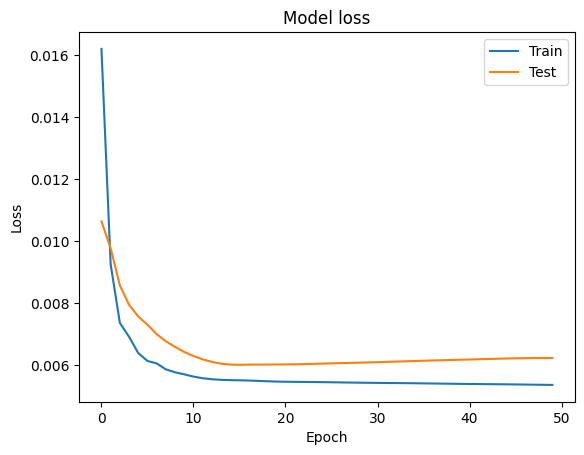

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### MAPE Train

In [17]:
def inverse_transform(scaler, input):
  return input * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

# inverse_transform(scaler, predicted)

In [18]:
train_predict = model.predict(X_train).flatten()
train_predict_denorm = inverse_transform(scaler, train_predict)
y_train_denorm = inverse_transform(scaler, y_train)
mape_train = mean_absolute_percentage_error(y_train_denorm, train_predict_denorm)
mape_train

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


0.1898146508941863

### Plot Train Actual vs Predicted

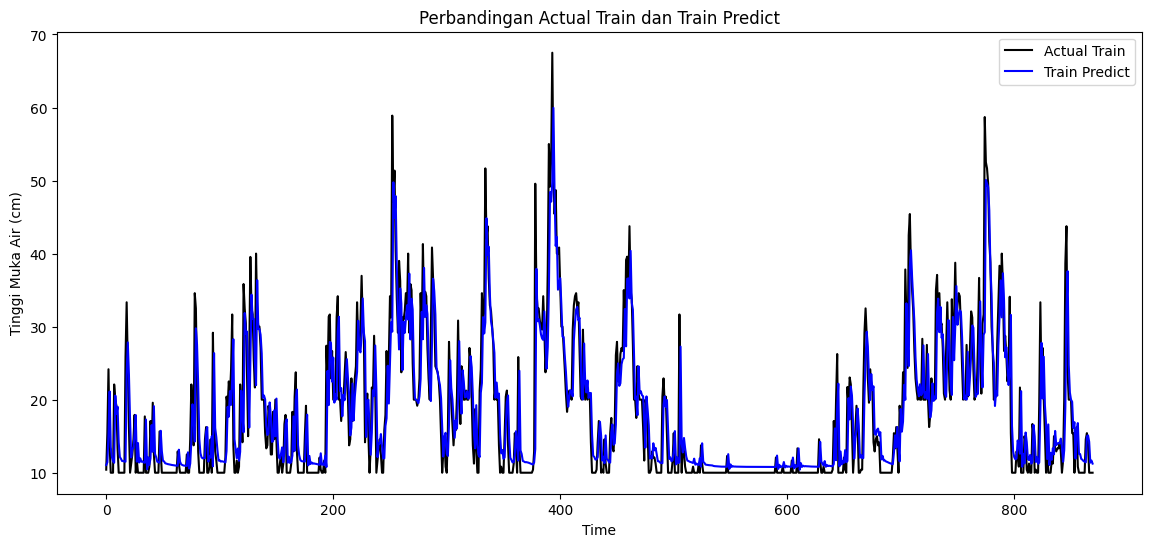

In [21]:
# Plot perbandingan actual train dan train predict ( MAPE = 19% )

plt.figure(figsize=(14, 6))
plt.plot(y_train_denorm, label='Actual Train', color = 'black')
plt.plot(train_predict_denorm, label='Train Predict', color = 'blue')
plt.title('Perbandingan Actual Train dan Train Predict')
plt.xlabel('Time')
plt.ylabel('Tinggi Muka Air (cm)')
plt.legend()
plt.show()

## Expanding Window Cross Validation

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0055 - val_loss: 0.0134
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0157
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0131
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 0.0095
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0133
Epoch 8/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0152
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 22.22176701267235 %
mape test = 25.883983344584355 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0125 - val_loss: 0.0303
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0080 - val_loss: 0.0164
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0065 - val_loss: 0.0202
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0071 - val_loss: 0.0178
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0076 - val_loss: 0.0298
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0081 - val_loss: 0.0283
Epoch 7/50
327/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0078 - val_loss: 0.0197
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 19.27847617585039 %
mape test = 24.225654090869984 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0116 - val_loss: 7.7605e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0070 - val_loss: 0.0010
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0069 - val_loss: 0.0010
Epoch 6/50
575/579 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070 - val_loss: 9.7333e-04
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 17.979460923691228 %
mape test = 16.91744593892495 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0119 - val_loss: 0.0033
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058 - val_loss: 0.0116
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 9/50
818/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 13

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0092 - val_loss: 0.0111
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0058 - val_loss: 0.0106
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0060 - val_loss: 0.0110
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0061 - val_loss: 0.0101
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0056 - val_loss: 0.0114
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0066 - val_loss: 0.0112
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0175
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0061 - val_loss: 0.0098
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0052 - val_loss: 0.0116
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0065 - val_loss: 0.0103
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━━━━━━

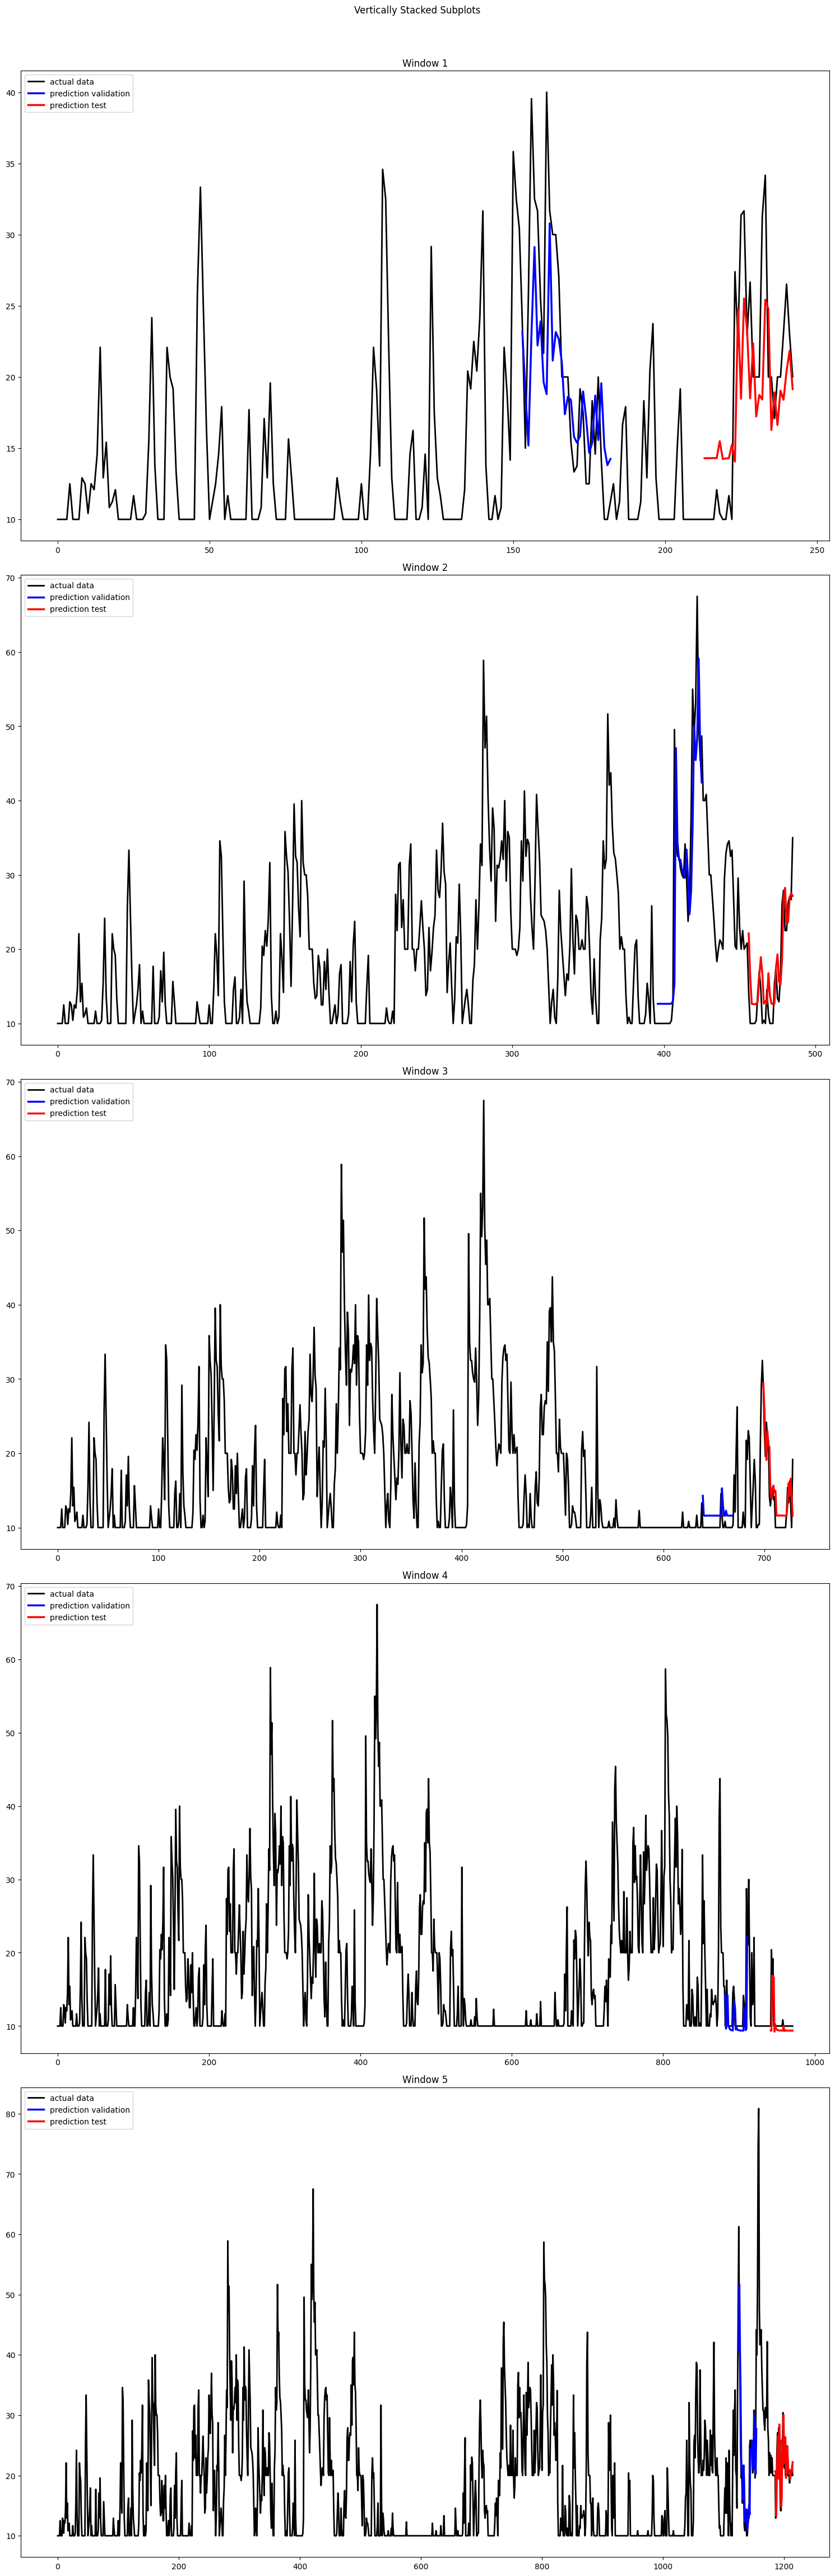


Final Average MAPE Validation: 0.1853
Final Average MAPE Test: 0.1881
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0055 - val_loss: 0.0134
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0037 - val_loss: 0.0157
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0131
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 0.0095
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0133
Epoch 8/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0152
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 22.22176701267235 %
mape test = 25.883983344584355 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0125 - val_loss: 0.0303
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0080 - val_loss: 0.0164
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0065 - val_loss: 0.0202
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - val_loss: 0.0178
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076 - val_loss: 0.0298
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0081 - val_loss: 0.0283
Epoch 7/50
331/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0078 - val_loss: 0.0197
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 19.27847617585039 %
mape test = 24.225654090869984 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0116 - val_loss: 7.7605e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070 - val_loss: 0.0010
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0069 - val_loss: 0.0010
Epoch 6/50
577/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0070 - val_loss: 9.7333e-04
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.979460923691228 %
mape test = 16.91744593892495 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0119 - val_loss: 0.0033
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0058 - val_loss: 0.0116
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 9/50
813/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 13

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0092 - val_loss: 0.0111
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - val_loss: 0.0106
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0060 - val_loss: 0.0110
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0061 - val_loss: 0.0101
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0056 - val_loss: 0.0114
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - val_loss: 0.0112
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0063 - val_loss: 0.0175
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0061 - val_loss: 0.0098
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0052 - val_loss: 0.0116
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0065 - val_loss: 0.0103
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1853
Final Average MAPE Test: 0.1881
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0055 - val_loss: 0.0134
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0157
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0131
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0095
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0133
Epoch 8/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0152
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 22.22176701267235 %
mape test = 25.883983344584355 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0125 - val_loss: 0.0303
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0080 - val_loss: 0.0164
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0065 - val_loss: 0.0202
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - val_loss: 0.0178
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0076 - val_loss: 0.0298
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0081 - val_loss: 0.0283
Epoch 7/50
330/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0078 - val_loss: 0.0197
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 19.27847617585039 %
mape test = 24.225654090869984 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0116 - val_loss: 7.7605e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0070 - val_loss: 0.0010
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069 - val_loss: 0.0010
Epoch 6/50
574/579 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0070 - val_loss: 9.7333e-04
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 17.979460923691228 %
mape test = 16.91744593892495 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0119 - val_loss: 0.0033
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0058 - val_loss: 0.0116
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 9/50
821/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 13

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0092 - val_loss: 0.0111
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0058 - val_loss: 0.0106
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0060 - val_loss: 0.0110
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0061 - val_loss: 0.0101
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0056 - val_loss: 0.0114
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - val_loss: 0.0112
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0063 - val_loss: 0.0175
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0061 - val_loss: 0.0098
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0052 - val_loss: 0.0116
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0065 - val_loss: 0.0103
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1853
Final Average MAPE Test: 0.1881
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0055 - val_loss: 0.0134
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - val_loss: 0.0157
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0131
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0095
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0133
Epoch 8/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0152
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 22.22176701267235 %
mape test = 25.883983344584355 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0125 - val_loss: 0.0303
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0080 - val_loss: 0.0164
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0065 - val_loss: 0.0202
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - val_loss: 0.0178
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0076 - val_loss: 0.0298
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0081 - val_loss: 0.0283
Epoch 7/50
331/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0078 - val_loss: 0.0197
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 19.27847617585039 %
mape test = 24.225654090869984 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0116 - val_loss: 7.7605e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0070 - val_loss: 0.0010
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0069 - val_loss: 0.0010
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0070 - val_loss: 9.7333e-04
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.979460923691228 %
mape test = 16.91744593892495 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0119 - val_loss: 0.0033
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058 - val_loss: 0.0116
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 9/50
820/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 13

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0092 - val_loss: 0.0111
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0058 - val_loss: 0.0106
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0060 - val_loss: 0.0110
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0061 - val_loss: 0.0101
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0056 - val_loss: 0.0114
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0066 - val_loss: 0.0112
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0063 - val_loss: 0.0175
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0061 - val_loss: 0.0098
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0052 - val_loss: 0.0116
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0065 - val_loss: 0.0103
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1853
Final Average MAPE Test: 0.1881
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0278 - val_loss: 0.0402
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0229 - val_loss: 0.0136
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - val_loss: 0.0173
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0101 - val_loss: 0.0134
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0086 - val_loss: 0.0275
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - val_loss: 0.0173
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - val_loss: 0.0115
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0457
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - val_loss: 0.0201
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0080


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0245 - val_loss: 0.0362
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0106 - val_loss: 0.0178
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0241
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0085 - val_loss: 0.0191
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0091 - val_loss: 0.0205
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096 - val_loss: 0.0214
Epoch 7/50
331/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0090 - val_loss: 0.0264
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 34.48952900011214 %
mape test = 45.70260825142156 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0220 - val_loss: 0.0052
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0081 - val_loss: 0.0115
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0088 - val_loss: 0.0077
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0092 - val_loss: 8.9059e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0102 - val_loss: 0.0013
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0079 - val_loss: 0.0017
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0087 - val_loss: 0.0011
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0124 - val_loss: 0.0028
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0166 - val_loss: 0.0057
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0072 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 7/50
819/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0085 - val_loss: 0.0036
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 16.395871269306674 %
mape test = 14.05783590909614 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0357 - val_loss: 0.0156
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0083 - val_loss: 0.0102
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0084 - val_loss: 0.0105
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0080 - val_loss: 0.0130
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0076 - val_loss: 0.0112
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0078 - val_loss: 0.0181
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0071 - val_loss: 0.0107
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - val_loss: 0.0139
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0075 - val_loss: 0.0134
Epoch 11/50
1059/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070Restoring model weights from the end of the best epoch.
10

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2220
Final Average MAPE Test: 0.2395
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0278 - val_loss: 0.0402
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0229 - val_loss: 0.0136
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - val_loss: 0.0173
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101 - val_loss: 0.0134
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0086 - val_loss: 0.0275
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - val_loss: 0.0173
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - val_loss: 0.0115
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0457
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - val_loss: 0.0201
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0080


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0245 - val_loss: 0.0362
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0106 - val_loss: 0.0178
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0087 - val_loss: 0.0241
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0085 - val_loss: 0.0191
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0205
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096 - val_loss: 0.0214
Epoch 7/50
328/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0264
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 34.48952900011214 %
mape test = 45.70260825142156 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0220 - val_loss: 0.0052
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0081 - val_loss: 0.0115
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0088 - val_loss: 0.0077
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0092 - val_loss: 8.9059e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0102 - val_loss: 0.0013
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0079 - val_loss: 0.0017
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0087 - val_loss: 0.0011
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0124 - val_loss: 0.0028
Epoch 9/50
569/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0166 - val_loss: 0.0057
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0072 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 7/50
813/822 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0085 - val_loss: 0.0036
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 16.395871269306674 %
mape test = 14.05783590909614 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0357 - val_loss: 0.0156
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0083 - val_loss: 0.0102
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0084 - val_loss: 0.0105
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0080 - val_loss: 0.0130
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0076 - val_loss: 0.0112
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0078 - val_loss: 0.0181
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0071 - val_loss: 0.0107
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0066 - val_loss: 0.0139
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0075 - val_loss: 0.0134
Epoch 11/50
1057/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070Restoring model weights from the end of the best epoch.

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2220
Final Average MAPE Test: 0.2395
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0278 - val_loss: 0.0402
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0229 - val_loss: 0.0136
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - val_loss: 0.0173
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0101 - val_loss: 0.0134
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0086 - val_loss: 0.0275
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - val_loss: 0.0173
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - val_loss: 0.0115
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - val_loss: 0.0457
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - val_loss: 0.0201
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0080


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0245 - val_loss: 0.0362
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0106 - val_loss: 0.0178
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0241
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0085 - val_loss: 0.0191
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0205
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0096 - val_loss: 0.0214
Epoch 7/50
329/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0264
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 34.48952900011214 %
mape test = 45.70260825142156 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0220 - val_loss: 0.0052
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0081 - val_loss: 0.0115
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0088 - val_loss: 0.0077
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 8.9059e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0102 - val_loss: 0.0013
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0079 - val_loss: 0.0017
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0087 - val_loss: 0.0011
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0124 - val_loss: 0.0028
Epoch 9/50
573/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0166 - val_loss: 0.0057
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0072 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 7/50
820/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0085 - val_loss: 0.0036
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 16.395871269306674 %
mape test = 14.05783590909614 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0357 - val_loss: 0.0156
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0083 - val_loss: 0.0102
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0084 - val_loss: 0.0105
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0080 - val_loss: 0.0130
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0076 - val_loss: 0.0112
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0078 - val_loss: 0.0181
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0071 - val_loss: 0.0107
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0066 - val_loss: 0.0139
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0075 - val_loss: 0.0134
Epoch 11/50
1063/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070Restoring model weights from the end of the best epoch.


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2220
Final Average MAPE Test: 0.2395
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0278 - val_loss: 0.0402
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0229 - val_loss: 0.0136
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - val_loss: 0.0173
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101 - val_loss: 0.0134
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - val_loss: 0.0275
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0091 - val_loss: 0.0173
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0115
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0457
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - val_loss: 0.0201
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0080


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0245 - val_loss: 0.0362
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0106 - val_loss: 0.0178
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0241
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0085 - val_loss: 0.0191
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0205
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0096 - val_loss: 0.0214
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0090 - val_loss: 0.0264
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 34.48952900011214 %
mape test = 45.70260825142156 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0220 - val_loss: 0.0052
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0081 - val_loss: 0.0115
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0088 - val_loss: 0.0077
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 8.9059e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0102 - val_loss: 0.0013
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0079 - val_loss: 0.0017
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0087 - val_loss: 0.0011
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0124 - val_loss: 0.0028
Epoch 9/50
573/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0166 - val_loss: 0.0057
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0072 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 7/50
817/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0085 - val_loss: 0.0036
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 16.395871269306674 %
mape test = 14.05783590909614 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0357 - val_loss: 0.0156
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0083 - val_loss: 0.0102
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0084 - val_loss: 0.0105
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0080 - val_loss: 0.0130
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0076 - val_loss: 0.0112
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0078 - val_loss: 0.0181
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0071 - val_loss: 0.0107
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0066 - val_loss: 0.0139
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0075 - val_loss: 0.0134
Epoch 11/50
1060/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070Restoring model weights from the end of the best epoch.
10

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2220
Final Average MAPE Test: 0.2395
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0052 - val_loss: 0.0276
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0181
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0187
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057 - val_loss: 0.0190
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - val_loss: 0.0180
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056 - val_loss: 0.0179
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030 - val_loss: 0.0152
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 0.0138
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0187
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 0.0131
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074 - val_loss: 0.0169
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0116

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0140 - val_loss: 0.0279
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0089 - val_loss: 0.0201
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0084 - val_loss: 0.0196
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0070 - val_loss: 0.0192
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0068 - val_loss: 0.0201
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0071 - val_loss: 0.0190
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0069 - val_loss: 0.0167
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0057 - val_loss: 0.0187
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0061 - val_loss: 0.0164
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - val_loss: 0.0184
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0067 - val_loss: 0.0170
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0142 - val_loss: 0.0011
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0078 - val_loss: 1.8710e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 6.3553e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0059 - val_loss: 7.4350e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 7/50
575/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 8.2876e-04
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 3.939228418516221 %
mape test = 12.803128346896212 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0147 - val_loss: 0.0033
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0033
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 9/50
812/822 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 16

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0102 - val_loss: 0.0142
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0052 - val_loss: 0.0107
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0061 - val_loss: 0.0103
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0057 - val_loss: 0.0119
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0049 - val_loss: 0.0096
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0057 - val_loss: 0.0098
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1627
Final Average MAPE Test: 0.1783
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0052 - val_loss: 0.0276
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - val_loss: 0.0181
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - val_loss: 0.0187
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057 - val_loss: 0.0190
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - val_loss: 0.0180
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - val_loss: 0.0179
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0152
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0138
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0187
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 0.0131
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074 - val_loss: 0.0169
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0116


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0140 - val_loss: 0.0279
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0201
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0084 - val_loss: 0.0196
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0070 - val_loss: 0.0192
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0068 - val_loss: 0.0201
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0071 - val_loss: 0.0190
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0069 - val_loss: 0.0167
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0057 - val_loss: 0.0187
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0061 - val_loss: 0.0164
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072 - val_loss: 0.0184
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0067 - val_loss: 0.0170
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0142 - val_loss: 0.0011
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0078 - val_loss: 1.8710e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0064 - val_loss: 6.3553e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0059 - val_loss: 7.4350e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 7/50
576/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 8.2876e-04
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 3.939228418516221 %
mape test = 12.803128346896212 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0147 - val_loss: 0.0033
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0033
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 9/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 16

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0102 - val_loss: 0.0142
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0052 - val_loss: 0.0107
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0061 - val_loss: 0.0103
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0057 - val_loss: 0.0119
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0049 - val_loss: 0.0096
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0057 - val_loss: 0.0098
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1627
Final Average MAPE Test: 0.1783
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0052 - val_loss: 0.0276
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0181
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0187
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057 - val_loss: 0.0190
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - val_loss: 0.0180
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056 - val_loss: 0.0179
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0152
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0138
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0187
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 0.0131
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074 - val_loss: 0.0169
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0116


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0140 - val_loss: 0.0279
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0201
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0084 - val_loss: 0.0196
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0070 - val_loss: 0.0192
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0068 - val_loss: 0.0201
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0071 - val_loss: 0.0190
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069 - val_loss: 0.0167
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0057 - val_loss: 0.0187
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0061 - val_loss: 0.0164
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - val_loss: 0.0184
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0067 - val_loss: 0.0170
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0142 - val_loss: 0.0011
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0078 - val_loss: 1.8710e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 6.3553e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0059 - val_loss: 7.4350e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 7/50
577/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 8.2876e-04
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 3.939228418516221 %
mape test = 12.803128346896212 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0147 - val_loss: 0.0033
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0067 - val_loss: 0.0033
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 9/50
812/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 16

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0102 - val_loss: 0.0142
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0052 - val_loss: 0.0107
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0061 - val_loss: 0.0103
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0057 - val_loss: 0.0119
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0049 - val_loss: 0.0096
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0057 - val_loss: 0.0098
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1627
Final Average MAPE Test: 0.1783
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0052 - val_loss: 0.0276
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0181
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0187
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057 - val_loss: 0.0190
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - val_loss: 0.0180
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - val_loss: 0.0179
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0152
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0138
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0187
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045 - val_loss: 0.0131
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074 - val_loss: 0.0169
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0116

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0140 - val_loss: 0.0279
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0089 - val_loss: 0.0201
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0084 - val_loss: 0.0196
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0070 - val_loss: 0.0192
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0068 - val_loss: 0.0201
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0071 - val_loss: 0.0190
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0069 - val_loss: 0.0167
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0057 - val_loss: 0.0187
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0061 - val_loss: 0.0164
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0072 - val_loss: 0.0184
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0067 - val_loss: 0.0170
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0142 - val_loss: 0.0011
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0078 - val_loss: 1.8710e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 6.3553e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0059 - val_loss: 7.4350e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 7/50
577/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 8.2876e-04
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 3.939228418516221 %
mape test = 12.803128346896212 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0147 - val_loss: 0.0033
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0033
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 9/50
819/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 16

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0102 - val_loss: 0.0142
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0052 - val_loss: 0.0107
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0061 - val_loss: 0.0103
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0057 - val_loss: 0.0119
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0049 - val_loss: 0.0096
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0057 - val_loss: 0.0098
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 12/50
1065/1065 ━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1627
Final Average MAPE Test: 0.1783
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0171
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0139
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0109
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 0.0116
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0130
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 10/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0041 - val_loss: 0.0132
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0138 - val_loss: 0.0235
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0075 - val_loss: 0.0159
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0064 - val_loss: 0.0190
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0067 - val_loss: 0.0175
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0073 - val_loss: 0.0264
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0077 - val_loss: 0.0254
Epoch 7/50
333/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0075 - val_loss: 0.0176
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 21.624187922805667 %
mape test = 27.716153428338075 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0116 - val_loss: 3.5540e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0066 - val_loss: 2.4941e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0018
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 9.5598e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0067 - val_loss: 0.0010
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 6.894894530193371 %
mape test = 11.961120401713494 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0115 - val_loss: 0.0032
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0056 - val_loss: 0.0086
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 9/50
821/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0059 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0123
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0063 - val_loss: 0.0103
Epoch 7/50
1058/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0060 - val_loss: 0.0170
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.976933821370054 %
mape test = 15.336023264649146 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1620
Final Average MAPE Test: 0.1795
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0051 - val_loss: 0.0171
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - val_loss: 0.0139
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0109
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - val_loss: 0.0116
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0130
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 10/50
84/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0132
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0138 - val_loss: 0.0235
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0075 - val_loss: 0.0159
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0064 - val_loss: 0.0190
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0067 - val_loss: 0.0175
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0073 - val_loss: 0.0264
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0077 - val_loss: 0.0254
Epoch 7/50
330/336 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0075 - val_loss: 0.0176
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 21.624187922805667 %
mape test = 27.716153428338075 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0116 - val_loss: 3.5540e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0066 - val_loss: 2.4941e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0018
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0064 - val_loss: 9.5598e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0067 - val_loss: 0.0010
Epoch 7/50
574/579 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 6.894894530193371 %
mape test = 11.961120401713494 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0115 - val_loss: 0.0032
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0056 - val_loss: 0.0086
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 9/50
821/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0059 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0123
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0063 - val_loss: 0.0103
Epoch 7/50
1059/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0060 - val_loss: 0.0170
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.976933821370054 %
mape test = 15.336023264649146 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1620
Final Average MAPE Test: 0.1795
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0171
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 0.0139
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0109
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 0.0116
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0130
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 10/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0132
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0138 - val_loss: 0.0235
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0075 - val_loss: 0.0159
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0064 - val_loss: 0.0190
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0067 - val_loss: 0.0175
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0073 - val_loss: 0.0264
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0077 - val_loss: 0.0254
Epoch 7/50
334/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0075 - val_loss: 0.0176
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 21.624187922805667 %
mape test = 27.716153428338075 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0116 - val_loss: 3.5540e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0066 - val_loss: 2.4941e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0018
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0064 - val_loss: 9.5598e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0067 - val_loss: 0.0010
Epoch 7/50
571/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 6.894894530193371 %
mape test = 11.961120401713494 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0115 - val_loss: 0.0032
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0056 - val_loss: 0.0086
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 9/50
819/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0059 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0055 - val_loss: 0.0123
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0063 - val_loss: 0.0103
Epoch 7/50
1060/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0060 - val_loss: 0.0170
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.976933821370054 %
mape test = 15.336023264649146 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1620
Final Average MAPE Test: 0.1795
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0171
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0139
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0109
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 0.0116
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0130
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 10/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0132
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0138 - val_loss: 0.0235
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0075 - val_loss: 0.0159
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0064 - val_loss: 0.0190
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0067 - val_loss: 0.0175
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0073 - val_loss: 0.0264
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0077 - val_loss: 0.0254
Epoch 7/50
334/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0075 - val_loss: 0.0176
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 21.624187922805667 %
mape test = 27.716153428338075 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0116 - val_loss: 3.5540e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0066 - val_loss: 2.4941e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0018
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 9.5598e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0067 - val_loss: 0.0010
Epoch 7/50
576/579 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 6.894894530193371 %
mape test = 11.961120401713494 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0115 - val_loss: 0.0032
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0056 - val_loss: 0.0086
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 9/50
819/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0059 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0123
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0063 - val_loss: 0.0103
Epoch 7/50
1064/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0060 - val_loss: 0.0170
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.976933821370054 %
mape test = 15.336023264649146 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1620
Final Average MAPE Test: 0.1795


In [22]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, figsize=(15, 15*5/1.6))
fig.suptitle('Vertically Stacked Subplots')

# Parameter sliding window
window_size = 243        # Train Window
n_test = 60              # Test Window
n_train_and_val = window_size - n_test
n_train = n_train_and_val - 60
shift = 243
n_windows1 = 5
n_total = len(data_series)
look_back = 30
time_step = 30

import itertools

config_params = {
    "learning_rate" : [0.01, 0.05, 0.001, 0.005],
    "batch_size" : [16, 32, 64, 128],
    "neurons" : [50],
}

average_mape_vals_by_param = []
average_mape_tests_by_param = []

for xs in itertools.product(*list(config_params.values())):
  current_param = dict()
  for i, key in enumerate(config_params.keys()):
    if key == "batch_size":
      bsize = xs[i]
    else:
      current_param[key] = xs[i]

  mape_vals = []
  mape_tests = []

  # Simpan nilai asli
  base_n_train = n_train
  base_n_train_and_val = n_train_and_val

  for i in range(n_windows1):
    current_n_train = base_n_train + i * shift
    current_n_train_and_val = base_n_train_and_val + i * shift
    end = current_n_train_and_val + n_test

    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = data_series[:end]  # expanding window
    train_and_val = window_data[:current_n_train_and_val]
    train = train_and_val[:current_n_train]
    val = train_and_val[current_n_train:]
    test = window_data[current_n_train_and_val:]

    try:

          train_generator = TimeseriesGenerator(train, train, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          val_generator = TimeseriesGenerator(val, val, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          test_generator = TimeseriesGenerator(test, test, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          model = create_model(current_param['neurons'], current_param['learning_rate'])

          # model.compile(optimizer='adam', loss='mean_squared_error')

          model.fit(train_generator, epochs=50, validation_data=val_generator, batch_size=bsize, callbacks=[EarlyStoppingAtMinLoss(patience=5)], verbose = 1)

          val_predictions = model.predict(val_generator)
          test_predictions  = model.predict(test_generator)

          val_predictions_descale = scaler.inverse_transform(val_predictions).flatten()
          test_predictions_descale = scaler.inverse_transform(test_predictions).flatten()

          train_actual = scaler.inverse_transform(train).flatten()
          val_actual = scaler.inverse_transform(val).flatten()
          test_actual = scaler.inverse_transform(test).flatten()

          all_actual = np.append(np.append(train_actual, val_actual), test_actual)

          mape_val = mean_absolute_percentage_error(val_actual[-len(val_generator):], val_predictions_descale)
          mape_test = mean_absolute_percentage_error(test_actual[-len(test_generator):], test_predictions_descale)

          mape_vals.append(mape_val)
          mape_tests.append(mape_test)

          print(f"mape validation = {mape_val * 100} %")
          print(f"mape test = {mape_test * 100} %")

          X_actual = np.arange(0, len(train) + len(val) + len(test))
          # X_train = np.arange(0, len(train))
          X_val = np.arange(len(train) + look_back, len(train) + len(val))
          X_test = np.arange(len(train) + len(val) + look_back, len(train) + len(val) + len(test))

          axs[i].plot(X_actual, all_actual, lw=2, color='black', label='actual data')
          axs[i].plot(X_val, val_predictions_descale, lw=2.5, color='blue', label='prediction validation')
          axs[i].plot(X_test, test_predictions_descale, lw=2.5, color='red', label='prediction test')
          axs[i].set_title(f'Window {i+1}')
          axs[i].legend(loc='upper left') # legend untuk setiap subplot window

    except Exception as e:
          print(f"Error pada Window {i+1}: {e}")
          continue

  # setelah proses looping selesai
  plt.tight_layout(rect=[0, 0, 1, 0.97])  # agar suptitle tidak ketiban
  plt.show()

  # Rata-rata MAPE akhir
  if mape_vals and mape_tests:
      final_mape_val = np.mean(mape_vals)
      final_mape_test = np.mean(mape_tests)
      print(f"\nFinal Average MAPE Validation: {final_mape_val:.4f}")
      print(f"Final Average MAPE Test: {final_mape_test:.4f}")
      average_mape_vals_by_param.append(final_mape_val)
      average_mape_tests_by_param.append(final_mape_test)

### Hyperparameter Summary (EWCV)

In [24]:
hyperparameter_summary = pd.DataFrame({
    "mape_vals" : average_mape_vals_by_param,
    "mape_tests" : average_mape_tests_by_param
})


hyperparameter_summary.sort_values("mape_tests")

,mape_vals,mape_tests
11,0.162687,0.178329
10,0.162687,0.178329
9,0.162687,0.178329
8,0.162687,0.178329
15,0.162026,0.179484
14,0.162026,0.179484
13,0.162026,0.179484
12,0.162026,0.179484
3,0.185303,0.188149
2,0.185303,0.188149


In [25]:
best_idx = int(hyperparameter_summary.sort_values("mape_tests").index[0])
best_idx

11

In [26]:
parameter_combinations = list(itertools.product(*list(config_params.values())))
best_parameter = parameter_combinations[best_idx]
best_param = dict()
for i, key in enumerate(config_params.keys()):
  best_param[key] = best_parameter[i]
best_param

{'learning_rate': 0.001, 'batch_size': 128, 'neurons': 50}

### Best Parameter (EWCV)

In [27]:
best_param = {'learning_rate': 0.001, 'batch_size': 128, 'neurons': 50}

In [28]:
def create_model(neurons, learning_rate):
    seed = 42
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [29]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Membagi dataset menjadi data latih dan data uji
train_size = 900
test_size = len(time_series_data) - train_size

train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu (jumlah waktu sebelum prediksi)
seq_length = 30 # Time Step

# Membuat dataset dengan sekuens deret waktu
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]
y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshaping data untuk LSTM (jumlah sampel, panjang sekuens, jumlah fitur)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = create_model(best_param['neurons'], best_param['learning_rate'])
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0292 - val_loss: 0.0167
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0147 - val_loss: 0.0159
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0117 - val_loss: 0.0132
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0110 - val_loss: 0.0122
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0104 - val_loss: 0.0119
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0101 - val_loss: 0.0116
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0097 - val_loss: 0.0113
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0094 - val_loss: 0.0110
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0092 - val_loss: 0.0108
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0090 - val_loss: 0.0105
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 13/50


### Plot Model Loss

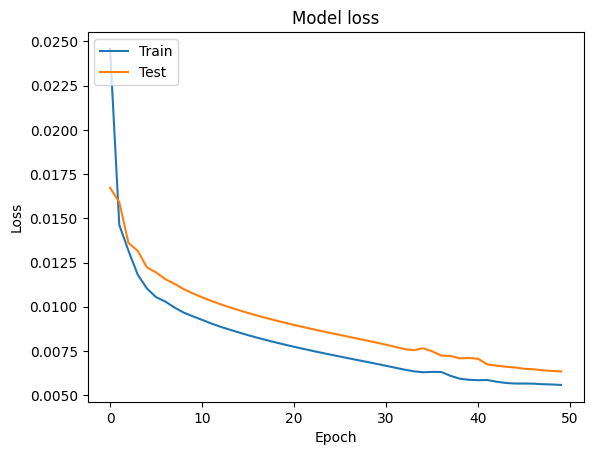

In [31]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### MAPE Train

In [32]:
def inverse_transform(scaler, input):
  return input * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

# inverse_transform(scaler, predicted)

In [33]:
train_predict = model.predict(X_train).flatten()
train_predict_denorm = inverse_transform(scaler, train_predict)
y_train_denorm = inverse_transform(scaler, y_train)
mape_train = mean_absolute_percentage_error(y_train_denorm, train_predict_denorm)
mape_train

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


0.21927034712378254

### Plot Train Actual vs Predicted

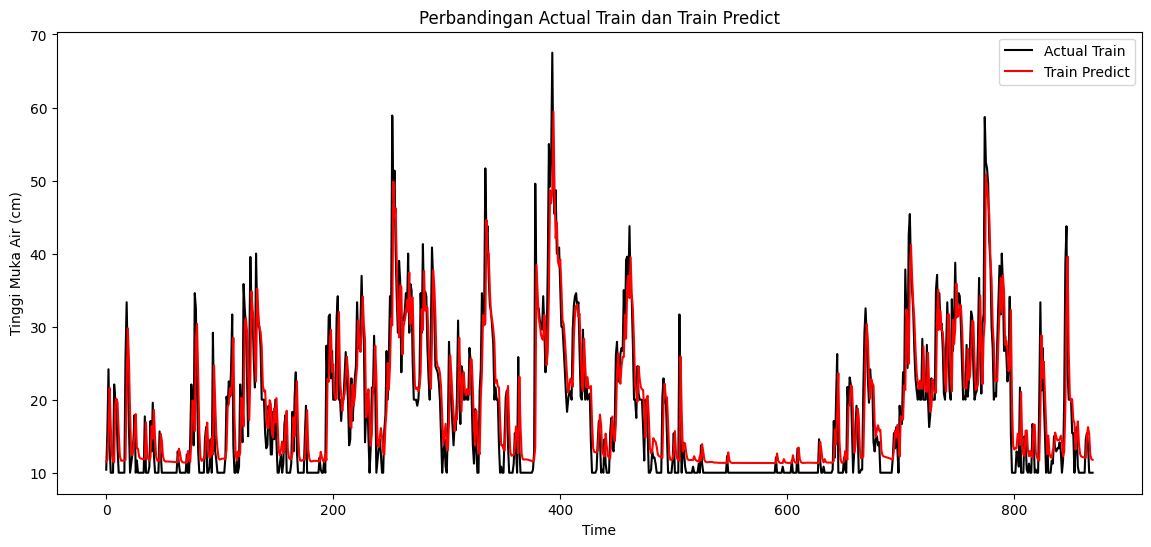

In [34]:
# Plot perbandingan actual train dan train predict ( MAPE = 21.92% )

plt.figure(figsize=(14, 6))
plt.plot(y_train_denorm, label='Actual Train', color = 'black')
plt.plot(train_predict_denorm, label='Train Predict', color = 'red')
plt.title('Perbandingan Actual Train dan Train Predict')
plt.xlabel('Time')
plt.ylabel('Tinggi Muka Air (cm)')
plt.legend()
plt.show()